### Get model metrics

#  MODIS Water Random Forest Hyperparameter Tuning

Version: 0.5.0

Date modified: 03.02.2023

Modified by: Amanda Burke

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
import optuna
import xgboost as xgb


from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
FIGURE_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

GPU = True
TILE_IN = 'Golden'
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = ['sur_refl_b01_1','sur_refl_b02_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)

TILE = 'h11v10'
DAY = 201
YEAR = 2006


# TILE = 'h21v10'
# DAY = 100
# YEAR = 2019

num_datapoints = 10000

FRAC_LAND = 0.5

##Add in the other stuff for tuning
frac_water = int(100*(1.0-FRAC_LAND))
if len(colsToDrop) >= 1:
    save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_no-vars_{'-'.join(colsToDrop)}"
else: 
     save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_all-vars"

print(save_file)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip', '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip
h11v10_201_2006_frac-water50_no-vars_sur_refl_b01_1-sur_refl_b02_1-sur_refl_b04_1-sur_refl_b05_1-sur_refl_b06_1-sur_refl_b07_1-ndvi-ndwi1-ndwi2


## Functions 

In [3]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

In [4]:
def rf_objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [5, 10, 30, 50, 80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    max_features = ['auto', 'sqrt', 'log2']
    
    # if TREES_AND_DEPTH_ONLY:
    #     param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
    #                'criterion':'gini', 
    #                'max_depth':trial.suggest_categorical('max_depth', max_depth), 
    #                'min_samples_split':2, 
    #                'min_samples_leaf':1, 
    #                'min_weight_fraction_leaf':0.0, 
    #                'max_features':'auto', 
    #                'max_leaf_nodes':None, 
    #                'min_impurity_decrease':0.0, 
    #                'bootstrap':True, 
    #                'oob_score':False, 
    #                'n_jobs':-1, 
    #                # 'random_state':42, 
    #                'verbose':0, 
    #                'warm_start':True, 
    #                'class_weight':None, 
    #                'ccp_alpha':0.0, 
    #                'max_samples':None
    #                   }
    # else:
    param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': trial.suggest_categorical('bootstrap', bootstrap),
                       'criterion':'gini', 
                       #'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 1e-8, 1.0, log=True), 
                       'max_features':trial.suggest_categorical('max_features', max_features), 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       # 'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = skRF(**param)
        model.fit(X_train, 
                  y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val, preds)
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
        print('Fold {}: {}'.format(idx, cv_scores[idx]))
    return np.mean(cv_scores)

rf_search_space={
    "n_estimators": [75, 100, 125, 150, 175, 200, 250, 300, 400, 500],
    "max_depth" : [5,10, 30, 50, 80, 90, 100, 110],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "min_samples_split" : [2, 4, 8, 10],
    "bootstrap" : [True, False],
    "max_features" : ['auto', 'sqrt', 'log2'],
    
}

In [5]:
def xgb_objective(trial):
    hyperparameters = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "hist",
        #"gpu_id": 0,
        "n_jobs": -1,
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 75, 100, 150, 175, 200, 250, 300, 500]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        #"lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        #"alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        #"colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth":  trial.suggest_int("max_depth", 30, 50, step=5), 
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight":  trial.suggest_int("min_child_weight", 2, 10), 
        #"eta":  trial.suggest_float("eta", 1e-8, 1.0, log=True), 
        # defines how selective algorithm is.
        #"gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True), 
        "grow_policy":  trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    classifier = xgb.XGBClassifier(**hyperparameters)
    X_train, X_val, y_train, y_val = train_test_split(X,y)
    eval_set = [(X_train, y_train), (X_val, y_val)]
    eval_metric = ["error","auc"]
    classifier.fit(X_train, 
                   y_train, 
                   eval_set=eval_set, 
                   eval_metric=eval_metric, 
                   early_stopping_rounds=10, 
                   callbacks=[pruning_callback],
                   verbose=False)
    preds = classifier.predict(X_test)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    print('Confusion matrix')
    # From docs: tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print('TP: {:9} FN: {:9}'.format(tp, fn))
    print('FP: {:9} TN: {:9}'.format(fp, tn))
    print('MCC: {}'.format(mcc))
    print('Precision: {}'.format(precision))
    print('F1 score: {}'.format(f1))
    return f1

xg_search_space={
    "n_estimators": [50, 75, 100, 150, 175, 200, 250, 300, 500],
    "max_depth" : [30,35,40,45,50],
    "booster": ["gbtree", "dart"],
    "subsample": [0.2, 1.0],
    "min_child_weight": [2,10],
    "grow_policy": ["depthwise", "lossguide"],
    
    }

In [6]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'): os.remove('tmp.vrt')
    
    return img

In [7]:
def predictRaster(img_chunk, classifier, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [8]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 


# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

## Data 
- Read in to cuDF or pandas Dataframe
- Drop unnecessary columns
- Clean data
- Split into Xs and Ys
- Train-test split

In [4]:
colsToDrop, colsToDropTraining

(['sur_refl_b01_1',
  'sur_refl_b02_1',
  'sur_refl_b04_1',
  'sur_refl_b05_1',
  'sur_refl_b06_1',
  'sur_refl_b07_1',
  'ndvi',
  'ndwi1',
  'ndwi2'],
 ['sur_refl_b01_1',
  'sur_refl_b02_1',
  'sur_refl_b04_1',
  'sur_refl_b05_1',
  'sur_refl_b06_1',
  'sur_refl_b07_1',
  'ndvi',
  'ndwi1',
  'ndwi2',
  'x_offset',
  'y_offset',
  'year',
  'julian_day',
  'tileID'])

In [4]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

Imbalancing data, sampling 0.5 from land, 0.5 from water
subset data shape: (10000, 1), (10000,)


In [23]:
_ = [print(column) for column in X.columns]

sur_refl_b03_1


# Model definition and training

Set TREES_AND_DEPTH_ONLY to True if you only want to tune number of estimators and max_depth.

If you want to only exhaust the search space above, set `GRID_SEARCH = True`.

### Start hyperparameter tuning trials.

Ex output: Trial 0 finished with values: [0.9527224325581133, 0.9667626330841518, 9684.0] and parameters:

The metrics in order are: [precision, f1, false positives]

In [24]:
TREES_AND_DEPTH_ONLY = False
GRID_SEARCH = True

In [25]:
%%time

optuna.logging.set_verbosity(optuna.logging.INFO)
if GRID_SEARCH:
    study = optuna.create_study(study_name='RF Tuning Grid Search', 
                                direction='maximize',
                                sampler=optuna.samplers.GridSampler(rf_search_space))
    
else:
    study = optuna.create_study(study_name='RF Tuning',
                                direction='maximize')
#Objective is under the functions area

#####################################################################
#CHANGE HERE FOR DIFFERENT MODELING TYPE
#rf_objective or xgb_objective
#####################################################################

study.optimize(rf_objective, n_trials=5, timeout=30*60)

[I 2023-04-20 12:46:51,016] A new study created in memory with name: RF Tuning Grid Search


Fold 0: 0.814506044185077
Fold 1: 0.8203445447087777
Fold 2: 0.8015107007973143
Fold 3: 0.8125260960334029


[I 2023-04-20 12:46:52,289] Trial 0 finished with value: 0.8084496763150388 and parameters: {'n_estimators': 125, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8084496763150388.


Fold 4: 0.7933609958506225
Fold 0: 0.8183319570602807
Fold 1: 0.8257482574825749
Fold 2: 0.8135034993824619
Fold 3: 0.8213399503722084


[I 2023-04-20 12:46:57,741] Trial 1 finished with value: 0.8159821012805578 and parameters: {'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 1 with value: 0.8159821012805578.


Fold 4: 0.8009868421052632
Fold 0: 0.8257349808265871
Fold 1: 0.82920688208141
Fold 2: 0.8123415046491969
Fold 3: 0.8198810535259133


[I 2023-04-20 12:46:59,942] Trial 2 finished with value: 0.8189615466370036 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 2 with value: 0.8189615466370036.


Fold 4: 0.8076433121019109
Fold 0: 0.8181063122923589
Fold 1: 0.8229038854805726
Fold 2: 0.8068134607395098
Fold 3: 0.8167014613778705


[I 2023-04-20 12:47:02,371] Trial 3 finished with value: 0.8121106507881575 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 2 with value: 0.8189615466370036.


Fold 4: 0.7960281340504757
Fold 0: 0.8183698800165494
Fold 1: 0.8263917525773197
Fold 2: 0.8132231404958677
Fold 3: 0.8213244481466055


[I 2023-04-20 12:47:07,989] Trial 4 finished with value: 0.81698441956712 and parameters: {'n_estimators': 500, 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 2 with value: 0.8189615466370036.


Fold 4: 0.8056128765992571
CPU times: user 1min 6s, sys: 7.78 s, total: 1min 14s
Wall time: 17 s


## Get metrics from the overall hyperparameter tuning

In [26]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)


Number of finished trials: 5
{'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}


## Output hyperparameter files

In [27]:
trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = pd.DataFrame.from_dict(best_trial_params, orient="index")

# print(f"{save_file}_hyperopt_tuning_trial_{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')}_rf.csv")

# study_df.to_csv(f"{save_file}_hyperopt_tuning_trial_rf.csv") #datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')}_rf.csv")
study_df

[0.8189615466370036]
     n_estimators: 250
     max_depth: 10
     min_samples_split: 2
     min_samples_leaf: 4
     bootstrap: False
     max_features: log2


,0
n_estimators,250
max_depth,10
min_samples_split,2
min_samples_leaf,4
bootstrap,False
max_features,log2


### Visualize the optimization history

<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

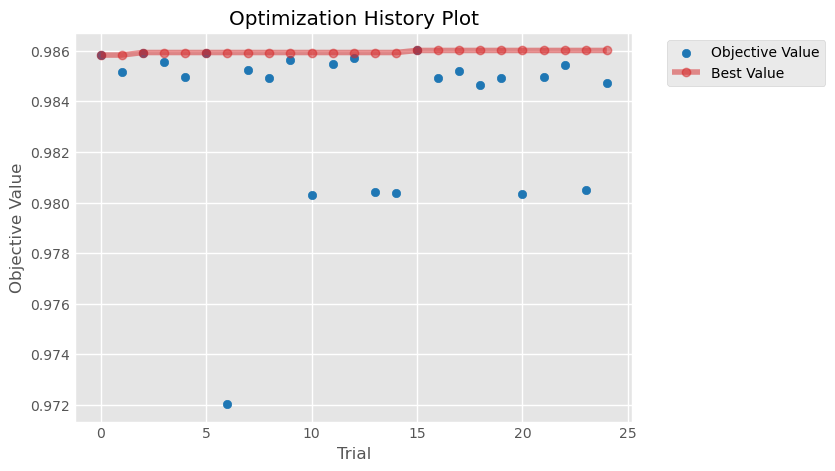

In [15]:
optuna.visualization.matplotlib.plot_optimization_history(study)

### Visualize hyperparameter importances

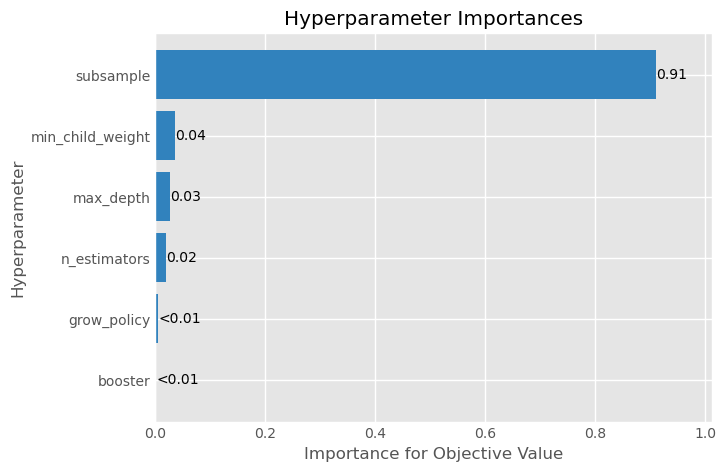

In [17]:
try:
    optuna.visualization.matplotlib.plot_param_importances(study)
except:
    print('Tuning only one hyper-parameter')

# Training the model with the best hyperparamers

In [106]:
#All variables, uncomment these indivudually to get out images
# 22 trials, even balance, no extra data points. v4.2
#best_trial_params = {'n_estimators': 300, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9809418632345569


#####CHANGE THE FRAC WITH THESE
# Number of finished trials: 25, no extra data points, v4.2, 60% water and 40% land 
# best_trial_params = {'n_estimators': 100, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9866621307852173

# Number of finished trials: 25, no extra data points, v4.2, 65% water and 35% land 
# best_trial_params = {'n_estimators': 300, 'max_depth': 90, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9871643995259538

# Number of finished trials: 25, no extra data points, v4.2, 70% water and 30% land 
#best_trial_params = {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}
# 0.9879873125723287

# Number of finished trials: 25, no extra data points, v4.2, 75% water and 25% land 
#best_trial_params = {'n_estimators': 300, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}
# 0.9889775845262525

#####CHANGE THE COLUMNS
# Number of finished trials: 25, no extra data points, v4.2, 70% water and 30% land, no ndvi
#best_trial_params = {'n_estimators': 300, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9899259722903564

# Number of finished trials: 25, no extra data points, v4.2, 45% land 55% water, no ndvi
best_trial_params = {'n_estimators': 500, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9857678701471905

#####################################################################

# #input the hyperparameter files, problem though with the int values being strings. 

# hyperparam_file = glob.glob(f"{save_file}_hyperopt_tuning_trial_rf*csv")[0]
# print(hyperparam_file)
# #best_trial_params =  pd.read_csv(hyperparam_file, header=None, index_col=0, squeeze = True).to_dict()
# best_trial_params = pd.read_csv(hyperparam_file,index_col=0).iloc[:,0].to_dict()
# print(best_trial_params)

#####################################################################

#change the below FRAC_LAND if using the above parameters
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=0.45,
                                trainTestSplit=True
                                )

#Follium stuff, putting this here so that I stop rewriting over files
# outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_75water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))


Imbalancing data, sampling 0.45 from land, 0.55 from water


#### Reading in other hyperparameter files
- Create a few lines of code that input the hyperparameter tuning 

In [33]:
X.describe()


,sur_refl_b03_1
count,10000.00000
mean,1044.09130
std,2032.93253
min,-100.00000
25%,191.00000
50%,310.00000
75%,691.00000
max,10433.00000


In [34]:
hyperparameters = best_trial_params
hyperparameters['n_jobs'] = -1
print('Using these params:')
print(hyperparameters)

##########################
#CHANGE TO RF OR XGB HERE 
##########################

tuned_classifier = skRF(**hyperparameters)
#tuned_classifier = xgb.XGBClassifier(**hyperparameters)


Using these params:
{'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2', 'n_jobs': -1}


In [35]:
%%time 
tuned_classifier.fit(X, y)


CPU times: user 2.34 s, sys: 195 ms, total: 2.53 s
Wall time: 406 ms


RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=4, n_estimators=250, n_jobs=-1)

# Testing: raster testing

In [36]:
import sys
sys.path.append('../../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [37]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)


#######
#in the TabularModisDataGenerator on line ~270 I commented out the line that would write out the qa mask
#qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

/css/modis/Collection6.1/L2G/MOD09GA/2006/*GA.A2006201.h11v10*.hdf
/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf
Julian day: 201
Files: {'SensorZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SensorZenith_1', 'SolarZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SolarZenith_1', 'state_1km_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:state_1km_1', 'sur_refl_b03_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1', 'sur_refl_b04_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1', 'sur_refl_b05_1':

In [38]:
vars_list_gq = [fn for fn in modisFilesList if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list


#IMPORTANT FOR QGIS POTENTIALLY BECAUSE OF LIST OF MODIS DATA

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_r

#### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [39]:
%%time

im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size
CPU times: user 6.65 s, sys: 987 ms, total: 7.64 s
Wall time: 10.9 s


['ndvi']

In [40]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, tuned_classifier, colsToDrop=colsToDrop)

Making predictions from raster
CPU times: user 11min 51s, sys: 1min 12s, total: 13min 4s
Wall time: 42.8 s


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [41]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
predictedWaterMask = matrix.reshape(shp)
predictedWaterMask.shape

(4800, 4800)

#### Import the QA Mask and the Water Mask for the GIVEN TILE

In [42]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(water_list)
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

['/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif']
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v10*.tif
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif


#### Mask out results if QA Mask says pixel is "bad"

In [43]:
maskedResult = np.where(qa_mask == 0, predictedWaterMask, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
# # waterMaskRavel = waterMasked.ravel()
# imWater = (waterMaskRavel == 1)

In [58]:
# plt.matshow(predictedWaterMask)
# plt.matshow(maskedResult-waterMasked)
# plt.matshow(waterMasked-maskedResult)
# plt.matshow(waterMaskMatrix)

# plt.matshow(waterMasked)
# plt.matshow(maskedResult)

## Output predicted raster to GeoTiff

In [44]:
#outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_65water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))
# outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_25trials_75water_noextradata_v42_allvars.tif'.format(YEAR, DAY, TILE, MODEL))
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}_xgb.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))


print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

2006_201_h11v10_predicted_rf_xgb.tif
waterMask_2006_qa_201.tif
2006_201_h11v10_predicted_probabilities_rf.tif
Transform
(-7783653.637667, 231.65635826395845, 0.0, -1111950.519667, 0.0, -231.65635826374995)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


## Folium Viewing

In [45]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 880.98, 0.00,-12122766.89|
| 0.00,-880.98,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 9911 Height: 6047


In [46]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)


# folium.Marker(location=[-16.4835, -72.9978]).add_to(m)

In [48]:
from folium import plugins

In [ ]:

m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())

m